# Homework 1
## Student : Jad El Karchi - AI

## Task 1. Analytical Computation of MAC Reduction [2 points]

Consider a convolutional layer with convolutional kernel of the shape $(C_{out}, C_{in}, k_{h}, k_{w})$, where:
$$k_h = k_w = 5, C_{in} = 3, C_{out} = 16$$

Assume we prune 25% of filters in convolutional layer to obtain a compressed convolutional layer.

Let input image be of size $(C_{in}, H_{in}, W_{in})$, where $H_{in} = W_{in} = 32$

1) Compute number of MAC in the initial conolutional layer, MAC_initial

2) Compute number of MAC in the compressed conolutional layer, Mac_compressed

3) Compute MAC reduction rate as (1 - MAC_compressed / MAC_initial)

1) In the initial convolutional layer, we have 16 filters of dimension (5, 5).
Each filter is applied on every possible pixel of the image.

Every kernel is computed on every pixel of the image;
Applying one kernel on one single pixel computes :

$ y_{ij} = b_{ij} \\
y_{ij} = y_{ij} + K_{1} × I_{i-\frac{k_{h}-1}{2}\,j-\frac{k_{w}-1}{2}}\\
\vdots\\
y_{ij} = y_{ij} + K_{k_{h}\,k_{w}} × I_{i+\frac{k_{h}-1}{2}\,j+\frac{k_{w}-1}{2}}$

Meaning, there are $k_{h} × k_{w}$ multiplications followed by additions for one pixel. The total number of pixels is : $W_{in} × H_{in} × C_{in}$

We conclude that the total number of MAC in the initial convolutional layer is :

$MAC_{initial} = C_{out} \times H_{in} × W_{in}  × C_{in} × k_{h} × k_{h}$

$MAC_{initial} = 1228800$

2) Now, if we compress the convolutional layer by pruning 25% of the filters, this means that $C_{out}$ goes from 16 to 12 and thus :
$MAC_{compressed} = 921600$

3) The pruning rate is :
$r = 1 - \frac{MAC_{compressed}}{MAC_{initial}} = 0.25$

## Task 2. Global Threshold for  Unstructed Pruning [1 point]

In this task for unstructed pruning you will prune neural network by removing all weights of convolutional layers that are smaller than some threshold.

In seminar we implemented local pruning strategy: removed some portion of weight elements for each layer seperately.

Now, you need to implement global pruning strategy, namely you need to find global threshold(one value for all neural network convolutional weights) that corresponds to x% pruning rate (ratio of weight elements that we prune or set to zero).

In [1]:
import torch
from utils import get_layer_by_name

def get_global_threshold(model, conv_list, prune_rate):
    """
    model: nn.Module
        neural network to be pruned
    conv_list: list(str)
        list of names of convolutional layers to be pruned
    prune_rate: float
        Value in range (0, 1) that corresponds to the ratio of pruned weight elements from all convolutional layers from `conv_list`.

    Return:
        threshold: float
            If we remove all convolutional weights elements less than `threshold` then we get pruning rate equaled `prune_rate`.
    """


    weights = [] # list to store weights of convolutional layers
    for conv_name in conv_list:
        # ANSWER
        conv = get_layer_by_name(model, conv_name)
        weights += list(conv.weight.data.abs())

    # hint: use torch.quantile to find threshold
    # ANSWER
    threshold = torch.quantile(torch.Tensor(weights[0]), prune_rate)
    print(f"Global threshold: {threshold.item():.3e}")
    return threshold

## Preparation for the following tasks 

In [2]:
import torch
import torch.nn as nn
from resnet_8x import ResNet18_8x, BasicBlock

import numpy as np

from copy import deepcopy

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model = ResNet18_8x(num_classes=100)
model.load_state_dict(torch.load("cifar100-resnet18_8x.pt"))

<All keys matched successfully>

In [4]:
from utils import batchnorm_callibration,\
                    get_validation_scores,\
                    fix_random_seed,\
                    get_cifar100_dataloader
                    
from pruning_utils import prune_unstructed,\
                    compute_nonzero_ratio,\
                    prune_structed

fix_random_seed(seed=42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_path = './'
batch_size = 256
num_workers = 0

train_loader, val_loader = get_cifar100_dataloader(dataset_path, batch_size, num_workers, download=True)
calibrate_batches = 200

Files already downloaded and verified
Files already downloaded and verified


## Task 3. Accuracy-Pruning rate Trade-off for Local Unstructed Pruning [1 points]

In this task you will investigate what happens with neural network accuracy if you prune only one Basic block from ResNet architecture.

And you will analyze how sensitive is the network accuracy to pruning of different Basic blocks.

Namely, you should do the following for each Basic block:

- Take an initial model

- For pruning rate from the list of considered pruning rates:
    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Compute accuracies for compressed model

After all computations you will get a dictionary `dict_unstructed`, where keys stands for Basic block names and `dict_unstructed[key]` is a tuple `(accs, ratios)`, where `accs` are accuracies corresponding for pruning rates `ratios`.

Hint: choose appropriate functions from `putils` to perform pruning routine


In [5]:
evaluated_basicblocks = [
    'layer1.0',
    'layer1.1',
    # 'layer2.0',
    # 'layer2.1',
    # 'layer3.0',
    # 'layer3.1',
    # 'layer4.0',
    # 'layer4.1'
]
strategy = "local"
prune_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

dict_unstructed = {}

try:
    dict_unstructed = np.load("results.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_unstructed:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, prune_ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [f'{bname}.conv1', f'{bname}.conv2']

        # ANSWER
        model_pruned = prune_unstructed(model, conv_list_local, strategy='global', prune_rate=get_global_threshold(model, conv_list_local, prune_rate)).to(device)
        nonzero_ratio, _ = compute_nonzero_ratio(model_pruned, conv_list_local)

        
        t0 = time()
        # your code for Task 6 starts here (no need to fill it in Task 3)
        # Calibrate batchnorms (you can use helper function as at the seminar or implement calibration routine yourself)
        # your code ends here 
        print(f'\tCalibration has taken {time() - t0: .3f}s')
        
        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        
        accs += [top1_acc]
        prune_ratios += [1 - nonzero_ratio] 

    dict_unstructed[bname] = [np.array(accs), np.array(prune_ratios)]
    np.save("results.npy", dict_unstructed)



Start computation for BasicBlock layer1.0...
Global threshold: 7.133e-04
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.1 have been computed
Global threshold: 1.798e-03
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.2 have been computed
Global threshold: 3.139e-03
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.3 have been computed
Global threshold: 4.937e-03
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.4 have been computed
Global threshold: 7.090e-03
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.5 have been computed
Global threshold: 1.001e-02
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.6 have been computed
Global threshold: 1.372e-02
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.7 have been computed
Global threshold: 1.932e-02
	Calibration has taken  0.000s
	Accuracies for pruning rate 0.8 have been computed
Global threshold: 2.805e-02
	Calibration has taken  0.000s
	Accur

## Task 4. Accuracy-Pruning rate Trade-off for Local Structed Pruning  [1 point]

Perform the same computations as in Task 3, but for structed pruning. To select channels estimate L1 norm of output channels of 1st convolution in Basic block (discussed at seminar).

That is for each Basic block for pruning rate from the list of considered pruning rates:

    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Compute accuracies for compressed model

Hint: choose appropriate functions from `putils` to perform pruning routine

In [6]:
evaluated_basicblocks = [
    'layer1.0',
    'layer1.1',
    # 'layer2.0',
    # 'layer2.1',
    # 'layer3.0',
    # 'layer3.1',
    # 'layer4.0',
    # 'layer4.1'
]
strategy = "local"
prune_rates = np.arange(0.1, 1.0, 0.1)

dict_structed = {}

try:
    dict_structed = np.load("results_structed.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_structed:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [bname]

        # ANSWER
        model_pruned = prune_structed(model, conv_list_local, prune_rate, channel_selection_strategy='l1').to(device)
        
        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        accs += [top1_acc]
        ratios += [prune_rate] 

    dict_structed[bname] = [np.array(accs), np.array(ratios)]
    np.save("results_structed.npy", dict_structed)



Start computation for BasicBlock layer1.0...
	Accuracies for pruning rate 0.1 have been computed
	Accuracies for pruning rate 0.2 have been computed
	Accuracies for pruning rate 0.30000000000000004 have been computed
	Accuracies for pruning rate 0.4 have been computed
	Accuracies for pruning rate 0.5 have been computed
	Accuracies for pruning rate 0.6 have been computed
	Accuracies for pruning rate 0.7000000000000001 have been computed
	Accuracies for pruning rate 0.8 have been computed
	Accuracies for pruning rate 0.9 have been computed


Start computation for BasicBlock layer1.1...
	Accuracies for pruning rate 0.1 have been computed
	Accuracies for pruning rate 0.2 have been computed
	Accuracies for pruning rate 0.30000000000000004 have been computed
	Accuracies for pruning rate 0.4 have been computed
	Accuracies for pruning rate 0.5 have been computed
	Accuracies for pruning rate 0.6 have been computed
	Accuracies for pruning rate 0.7000000000000001 have been computed
	Accuracies 

## Task 5. Discussion on Accuracy-Pruning rate Trade-off for Local Unstructed Pruning [3 points]

Compare accuracy-pruning rate trade-off for different Basic blocks.

a) What can you observe and conclude when compare models with compressed blocks obtained using unstructed and structed pruning?

b) What can you obeserve and conclude when compare models with compressed blocks, when corresponding blocks belong to one ResNet layer? (e.g., layer1.0 and layer1.1)

c) What can you observe and conclude when compare models with compressed blocks from different ResNet layers? (e.g., layer1.1 and layer4.1)



In [7]:
colors = "rbgk"
lines = ["-", "--"]

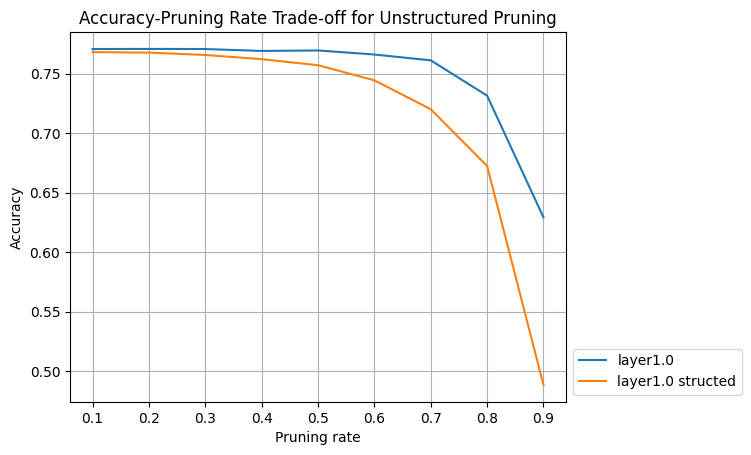

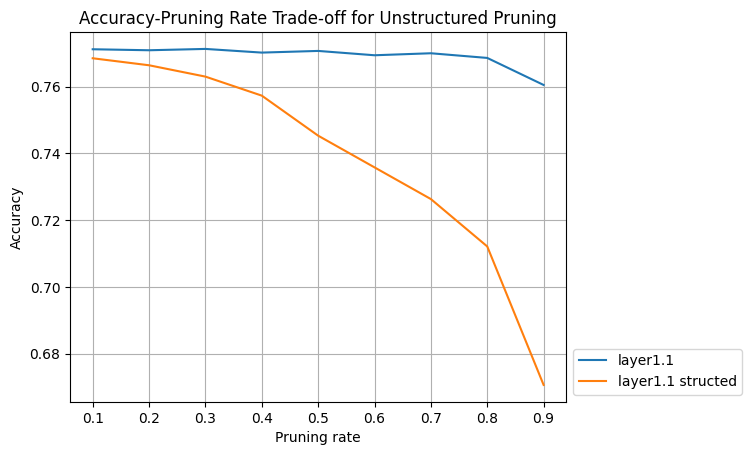

In [8]:
# helper visualization to compare results of structed and unstructed pruning

for bname in dict_structed.keys():
    accs_unstructed, _ = dict_unstructed[bname]
    accs_structed, prune_rate = dict_structed[bname]
    
    plt.plot(accs_unstructed, label=f"{bname}")
    plt.plot(accs_structed, label=f"{bname} structed")
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(prune_rate)), np.round(prune_rate, 2))
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Pruning Rate Trade-off for Unstructured Pruning')


    plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
    plt.grid(True)
    plt.show()

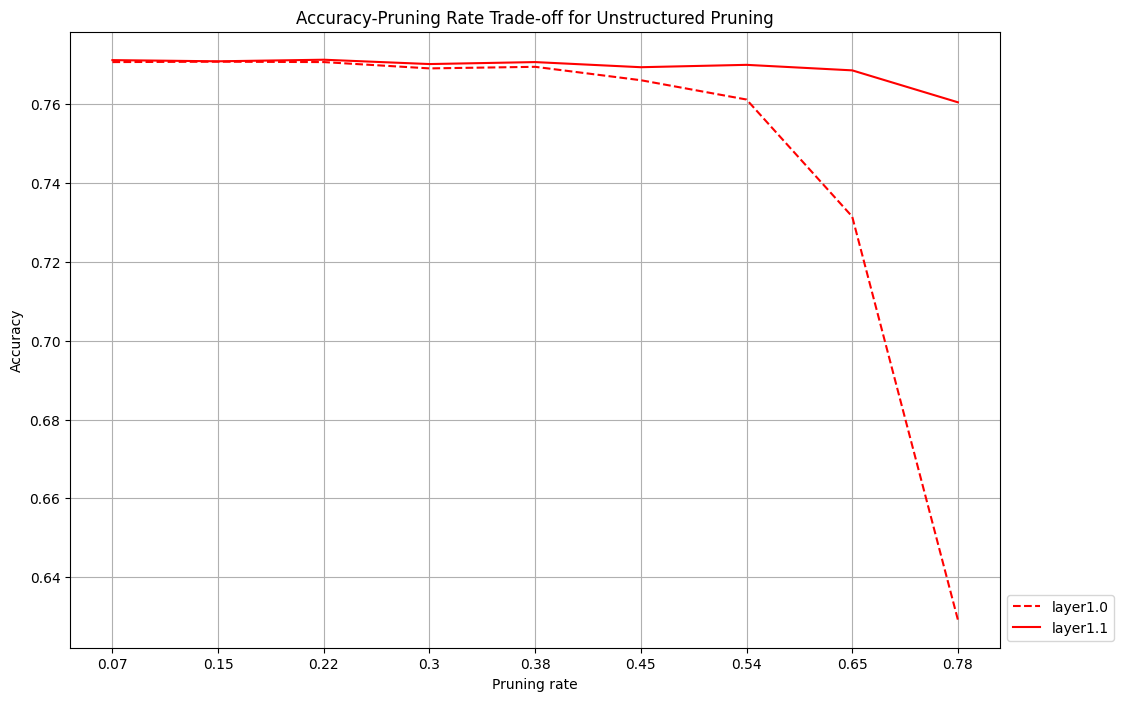

In [9]:
# helper visualization to analyze model sensitivity to the pruning of different basic blocks

plt.figure(figsize=(12, 8))

for bname, (accs, prune_ratios) in dict_unstructed.items():
    plt.plot(accs, lines[int(bname[-1])-1], color=colors[int(bname[5])-1], label=bname)
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(prune_ratios)), np.round(prune_ratios, 2))
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Pruning Rate Trade-off for Unstructured Pruning')

plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
plt.grid(True)

## Task 6. Influence of BatchNorm Calibration [2 point]

Perform the same computations as in Task 3, but adding calibration of BatchNorm statistics before accuracy computation.   

That is for each Basic block for pruning rate from the list of considered pruning rates:

    - Given pruning rate prune considered Basic block (You'll get a model, where one Basic block is compressed)
    - Calibrate statistics in Batch Norm layers
    - Compute accuracies for compressed model


Note: model calibration running time is approximately 4 times large than running time of model validation. Therefore, you can compare calibrated accuracies only for several layers (please find helper visualization code below).

In [10]:
# compute accuracies for pruned models and save them at `dict_unstructed_calibrated`.
# don't forget to change the name of the file with saved accuraces (i.e. rename`results.npy`)

# ANSWER
dict_unstructed_calibrated = {}  

# Hint: use similar logic for the code as in Task3
# ANSWER
evaluated_basicblocks = [
    'layer1.0',
    'layer1.1',
    # 'layer2.0',
    # 'layer2.1',
    # 'layer3.0',
    # 'layer3.1',
    # 'layer4.0',
    # 'layer4.1'
]
strategy = "local"
prune_rates = np.arange(0.1, 1.0, 0.1)

try:
    dict_unstructed_calibrated = np.load("res_calibrated.npy").item()
except:
    pass

for bname in evaluated_basicblocks:

    if bname in dict_unstructed_calibrated:
        print(f'Accuracies for BasicBlock {bname} have been already computed')
        continue
        
    print(f'\n\nStart computation for BasicBlock {bname}...')
    accs, prune_ratios = [], []
    for prune_rate in prune_rates:
        
        conv_list_local = [f'{bname}.conv1', f'{bname}.conv2']

        # ANSWER
        model_pruned = prune_unstructed(model, conv_list_local, strategy='global', prune_rate=get_global_threshold(model, conv_list_local, prune_rate)).to(device)
        nonzero_ratio, _ = compute_nonzero_ratio(model_pruned, conv_list_local)
        
        
        t0 = time()
        # your code for Task 6 starts here (no need to fill it in Task 3)
        # Calibrate batchnorms (you can use helper function as at the seminar or implement calibration routine yourself)
        # ANSWER
        model_pruned = batchnorm_callibration(model_pruned, train_loader, layer_name=conv_list_local[0], device=device)
        print(f'\tCalibration has taken {time() - t0: .3f}s')
        
        top1_acc, _ = get_validation_scores(model_pruned, val_loader, device=device)
        print(f'\tAccuracies for pruning rate {prune_rate} have been computed')
        
        accs += [top1_acc]
        prune_ratios += [1 - nonzero_ratio] 

    dict_unstructed_calibrated[bname] = [np.array(accs), np.array(prune_ratios)]
    np.save("res_calibrated.npy", dict_unstructed_calibrated)



Start computation for BasicBlock layer1.0...
Global threshold: 7.133e-04
	Calibration has taken  12.415s
	Accuracies for pruning rate 0.1 have been computed
Global threshold: 1.798e-03
	Calibration has taken  12.256s
	Accuracies for pruning rate 0.2 have been computed
Global threshold: 3.139e-03
	Calibration has taken  12.400s
	Accuracies for pruning rate 0.30000000000000004 have been computed
Global threshold: 4.937e-03
	Calibration has taken  12.339s
	Accuracies for pruning rate 0.4 have been computed
Global threshold: 7.090e-03
	Calibration has taken  12.343s
	Accuracies for pruning rate 0.5 have been computed
Global threshold: 1.001e-02
	Calibration has taken  12.356s
	Accuracies for pruning rate 0.6 have been computed
Global threshold: 1.372e-02
	Calibration has taken  12.326s
	Accuracies for pruning rate 0.7000000000000001 have been computed
Global threshold: 1.932e-02
	Calibration has taken  12.320s
	Accuracies for pruning rate 0.8 have been computed
Global threshold: 2.805e-0

Compare accuracies computed for calibrated and not calibrated models.

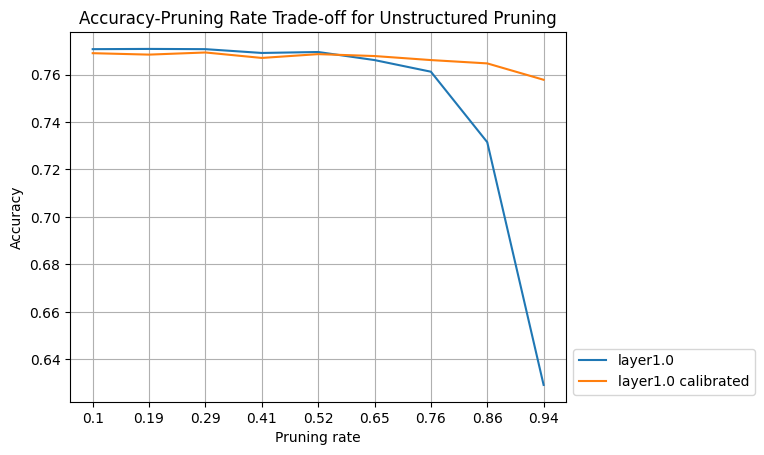

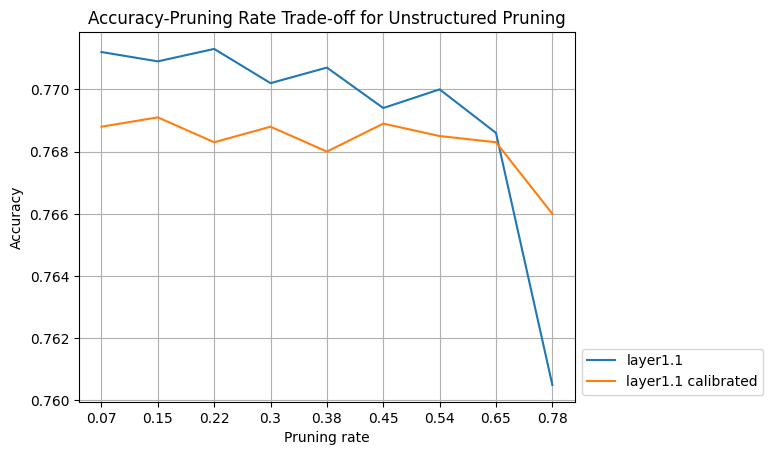

: 

In [11]:
for bname in dict_unstructed_calibrated.keys():
    accs_uncalibrated, ratios = dict_unstructed[bname]
    accs_calibrated, _ = dict_unstructed_calibrated[bname]
    
    plt.plot(accs_uncalibrated, label=f"{bname}")
    plt.plot(accs_calibrated, label=f"{bname} calibrated")
    plt.xlabel('Pruning rate')
    plt.xticks(np.arange(len(ratios)), np.round(ratios, 2))
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Pruning Rate Trade-off for Unstructured Pruning')


    plt.legend(loc='lower left', bbox_to_anchor=(1., 0., 0., 0.))
    plt.grid(True)
    plt.show()